In [418]:
import numpy as np
from math import e
from PIL import Image
import glob
import cv2
from matplotlib import pyplot as plt
import matplotlib
from math import exp
from math import sqrt
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import shift

In [2]:
def cen_in_mask(image,mask_shape):
    bg = Image.fromarray(np.zeros(mask_shape).astype(np.uint8))
    image = Image.fromarray(image)
    img_row, img_col = image.size
    bg_row, bg_col = bg.size
    bg.paste(image,((bg_row-img_row)//2,(bg_col-img_col)//2))
    return np.array(bg)

In [3]:
def circle_se(kernel_size,diameter):
    se = np.zeros((kernel_size,kernel_size))
    row,col = se.shape
    for i in range(row):
        for j in range(col):
            if (i-row/2)**2 + (j-col/2)**2 < diameter**2:
                se[i,j] = 1
    return se

In [927]:
# def dilation(image,se):
#     extra = se.shape[0]
#     new_shape = [sum(x) for x in zip(image.shape,(2*extra,2*extra))]
#     plane = cen_in_mask(image,tuple(new_shape))
#     row,col = plane.shape
#     kernel_coors = list(range(-extra//2+1,extra//2+1))
#     m,n = plane.shape
#     new_image = np.zeros(plane.shape)
#     for i in range(row):
#         for j in range(col):
#             if plane[i,j] == 255:
#                 for k in kernel_coors:
#                     for l in kernel_coors:
#                         if 0 <= i + k < m and 0 <= j + l < n and se[extra//2+k,extra//2+l] == 1:
#                             new_image[i+k,j+l] = 255
#     cropped = new_image[extra+1:m-extra+1,extra+1:n-extra+1]
#     return cropped.astype(np.int)

# def erosion(image,se):
#     extra = se.shape[0]
#     new_shape = [sum(x) for x in zip(image.shape,(2*extra,2*extra))]
#     plane = cen_in_mask(image,tuple(new_shape))
#     row,col = plane.shape
#     kernel_coors = list(range(-extra//2+1,extra//2+1))
#     m,n = plane.shape
#     new_image = np.zeros(plane.shape)
#     for i in range(row):
#         for j in range(col):
# #                 if plane[i,j] == 255:
#                     flag = 1
#                     for k in kernel_coors:
#                         for l in kernel_coors:
#                             if 0 <= i + k < m and 0 <= j + l < n and se[extra//2+k,extra//2+l] == 1 and plane[i+k,j+l] != 255:
#                                 flag *= 0
#                             elif 0 <= i + k < m and 0 <= j + l < n and se[extra//2+k,extra//2+l] == 1 and plane[i+k,j+l] == 255:
#                                 flag *= 1
#                     if flag == 1:
#                         new_image[i,j] = 255
#     cropped = new_image[extra+1:m-extra+1,extra+1:n-extra+1]
#     return cropped.astype(np.int)

def dilation(image,se):
    se = np.array(se).astype(np.int)
    extra = se.shape[0]
    kernel_coors = list(range(-extra//2+1,extra//2+1))
    new_image = np.copy(image.astype(np.int))
    for k in kernel_coors:
        for l in kernel_coors:
            if se[extra//2+k,extra//2+l] == 1:
                new_image = np.bitwise_or(new_image,shift(image,(k,l),cval=0))
    return new_image.astype(np.int)    

def erosion(image,se):
    se = np.array(se).astype(np.int)
    extra = se.shape[0]
    kernel_coors = list(range(-extra//2+1,extra//2+1))
    new_image = np.copy(image.astype(np.int))
    for k in kernel_coors:
        for l in kernel_coors:
            if se[extra//2+k,extra//2+l] == 1:
                new_image = np.bitwise_and(new_image,shift(image,(-k,-l),cval=0))
    return new_image.astype(np.int)    

def opening(image,se):
    result = erosion(image,se)
    result = dilation(result,se)
    return result

def closing(image,se):
    result = dilation(image,se)
    result = erosion(result,se)
    return result  

def hit_miss(image,se):
    result = np.bitwise_and(erosion(image,se),erosion(255-image,1-se))
    return result

def thick(image,ses,steps):
    new_image = np.copy(image)
    for st in range(steps):
        for se in ses:
            new_image = np.bitwise_or(new_image,hit_miss(new_image,se))
    return new_image

def thin(image,ses):
    new_image = np.copy(image)
    while True:
        for se in ses:
            temp = np.copy(new_image)
            new_image = new_image - hit_miss(new_image,se)
        if np.array_equal(temp,new_image):
            break
    return new_image

In [325]:
basics = []
bs1 = np.array([[0,0,0],[0.5,1,0.5],[1,1,1]])
bs2 = np.array([[0.5,0,0],[1,1,0],[1,1,0.5]])
for i in range(4):
    basics.append(np.rot90(bs1,i))
    basics.append(np.rot90(bs2,i))

In [5]:
images = np.array([cv2.imread(file,0) for file in glob.glob("C:/Users/sherw/OneDrive/Desktop/DIP_HW5/inputs/p3/*.png")])

# a

In [850]:
img1 = 255-images[1]
img1 = np.where(img1 > 128, 255, 0)

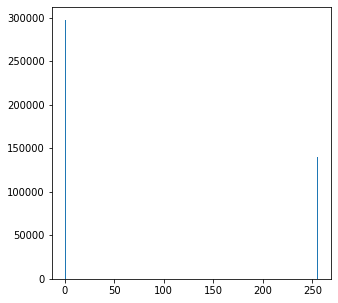

In [852]:
plt.hist(img1.ravel(),256,[0,256])
plt.show()

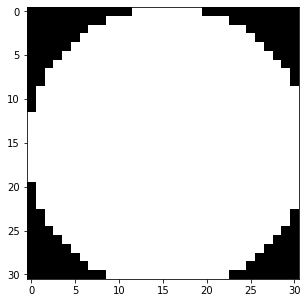

In [853]:
plt.rcParams['figure.figsize'] = [5,5]
a = circle_se(31,16)
plt.imshow(a,'gray')
plt.show()

In [854]:
a3 = circle_se(31,16)
di3 = closing(img1,a3)

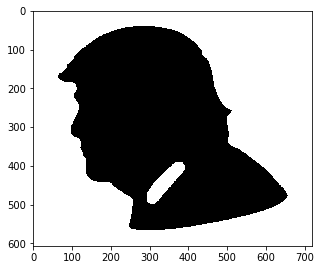

In [856]:
plt.rcParams['figure.figsize'] = [5,5]
plt.imshow(255-di3,'gray')
plt.show()

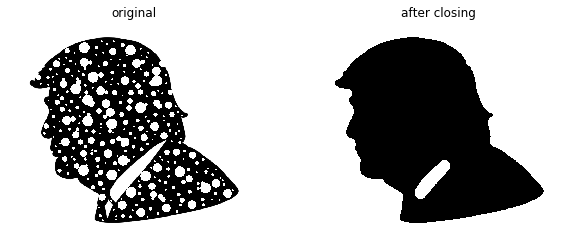

In [857]:
plt.rcParams['figure.figsize'] = [10,10]
plt.subplot(1,2,1)
plt.imshow(images[1],'gray',vmin = 0, vmax = 255)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(255-di3,'gray',vmin = 0, vmax = 255)
plt.title('after closing')
plt.axis('off')
plt.show()

# b

In [859]:
img2 = 255-images[2]

In [191]:
# se2 = np.rot90(np.diag(np.full(13,1)))+np.rot90(np.diag(np.ones(12),1))+np.rot90(np.diag(np.ones(12),-1))
# se2_rot = rotate(se2, angle=19).round()

In [426]:
se2 = np.rot90(np.diag(np.full(13,1)))
se2_rot = rotate(se2, angle=19).round()

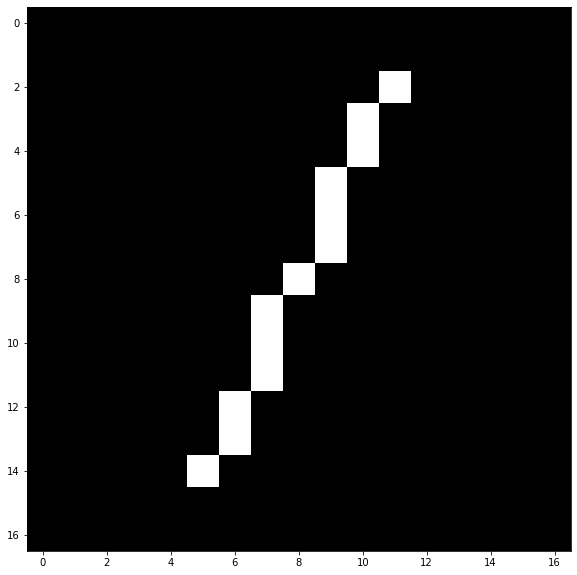

In [427]:
plt.imshow(se2_rot,'gray')
plt.show()

In [440]:
di2 = opening(img2,se2_rot)

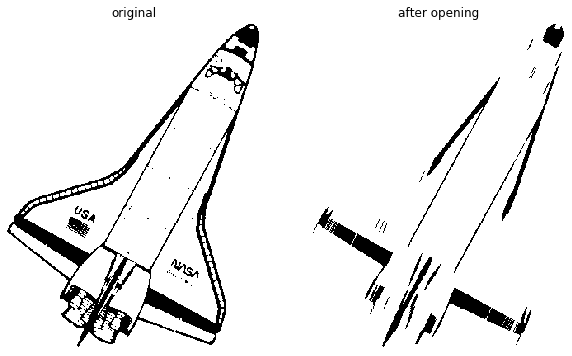

In [441]:
plt.rcParams['figure.figsize'] = [10,10]
plt.subplot(1,2,1)
plt.imshow(images[2],'gray',vmin = 0, vmax = 255)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(255-di2,'gray',vmin = 0, vmax = 255)
plt.title('after opening')
plt.axis('off')
plt.show()

# c

In [930]:
def erosion(image,se):
    extra = se.shape[0]
    new_shape = [sum(x) for x in zip(image.shape,(2*extra,2*extra))]
    plane = cen_in_mask(image,tuple(new_shape))
    row,col = plane.shape
    kernel_coors = list(range(-extra//2+1,extra//2+1))
    m,n = plane.shape
    new_image = np.zeros(plane.shape)
    for i in range(row):
        for j in range(col):
#                 if plane[i,j] == 255:
                    flag = 1
                    for k in kernel_coors:
                        for l in kernel_coors:
                            if 0 <= i + k < m and 0 <= j + l < n and se[extra//2+k,extra//2+l] == 1 and plane[i+k,j+l] != 255:
                                flag *= 0
                            elif 0 <= i + k < m and 0 <= j + l < n and se[extra//2+k,extra//2+l] == 1 and plane[i+k,j+l] == 255:
                                flag *= 1
                    if flag == 1:
                        new_image[i,j] = 255
    cropped = new_image[extra+1:m-extra+1,extra+1:n-extra+1]
    return cropped.astype(np.int)

In [888]:
img3 = 255- images[3]

In [918]:
img3_th = thick(img3,basics,3)

In [939]:
img3_d = dilation(img3,np.ones((5,5)))

In [941]:
img3_thin = thin(img3_d,basics)

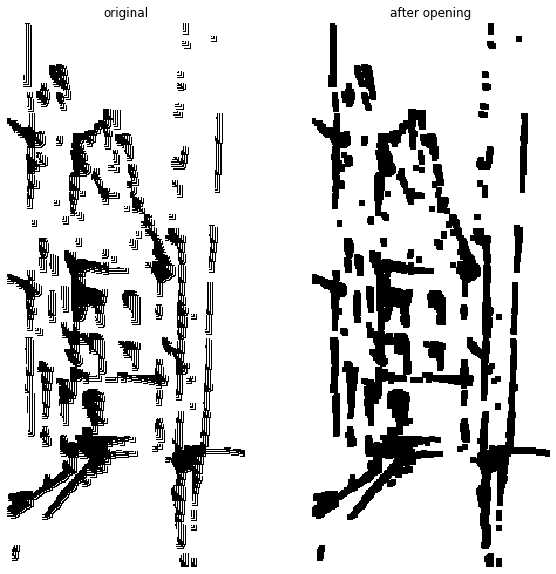

In [942]:
plt.rcParams['figure.figsize'] = [10,10]
plt.subplot(1,2,1)
plt.imshow(255-img3_thin,'gray',vmin = 0, vmax = 255)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(255-img3_d,'gray',vmin = 0, vmax = 255)
plt.title('after opening')
plt.axis('off')
plt.show()

# d

In [824]:
def erosion(image,se):
    extra = se.shape[0]
    kernel_coors = list(range(-extra//2+1,extra//2+1))
    new_image = np.copy(image)
    for k in kernel_coors:
        for l in kernel_coors:
            if se[extra//2+k,extra//2+l] == 1:
                new_image = np.bitwise_and(new_image,shift(image,(-k,-l),cval=0))
    return new_image.astype(np.int)    

In [583]:
img4 = 255-images[0]

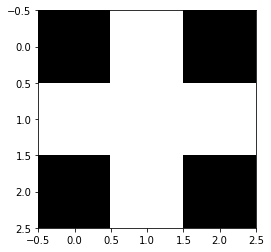

In [822]:
se = np.array([[0,1,0],[1,1,1],[0,1,0]])
plt.imshow(se,'gray')
plt.show()

In [814]:
img4_di = dilation(img4,se)
img4_cl = closing(img4_di,np.ones((3,3)))

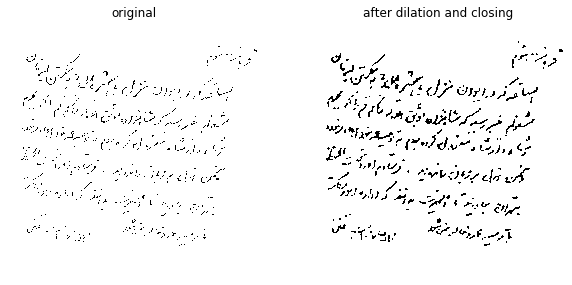

In [823]:
plt.rcParams['figure.figsize'] = [10,10]
plt.subplot(1,2,1)
plt.imshow(255-img4,'gray',vmin = 0, vmax = 255)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(255-img4_cl,'gray',vmin = 0, vmax = 255)
plt.title('after dilation and closing')
plt.axis('off')
plt.show()